In [300]:
from scipy.sparse import csr_matrix, csc_matrix

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances

import pickle
import re

import seaborn as sns

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [301]:
movies_cols = ["MovieID", "Title"]
movies = pd.read_csv('../moviesRecommender/ml-1m/movies.dat', names=movies_cols, 
                    sep="::", engine='python', usecols=range(2),
                    dtype={"MovieID":'int32', "Title":"str"})
ratings = pd.read_csv('../moviesRecommender/ml-1m/ratings.dat', delimiter="::", 
                     names=['UserID','MovieID','Rating'],
                     engine='python', usecols=range(3),
                     dtype={"UserID":'int32', "MovieID":"int32", "Rating":"int32"})

In [302]:
movies.head()

,MovieID,Title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [303]:
ratings.head()

,UserID,MovieID,Rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [304]:
unique_users = len(ratings['UserID'].unique())
unique_movies = len(movies['Title'].unique())

print("There are {} unique users and {} distinct movies.".format(unique_users, unique_movies))

There are 6040 unique users and 3883 distinct movies.



## Next up, we look at:
    - the frequency of each rating
    - the rating count for each movie

In [305]:
ratingsCountsTemp = pd.DataFrame(ratings.groupby('Rating').size(), columns = ['Count'])

In [306]:
totalRatings = unique_users * unique_movies
zeros_ratings = totalRatings - ratings.shape[0]

In [307]:
ratingsCounts = ratingsCountsTemp.append(pd.DataFrame({'Count': zeros_ratings}, index = [0]), verify_integrity=True).sort_index()
ratingsCounts

,Count
0,22453111
1,56174
2,107557
3,261197
4,348971
5,226310


#### We can see we have way more 0 (meaning unrated) than any other rating. Let us use log scaling in order to better visualize the distribution.

In [308]:
ratingsCounts['LogCount'] = np.log(ratingsCounts['Count'])
ratingsCounts

,Count,LogCount
0,22453111,16.926940
1,56174,10.936209
2,107557,11.585776
3,261197,12.473030
4,348971,12.762744
5,226310,12.329661


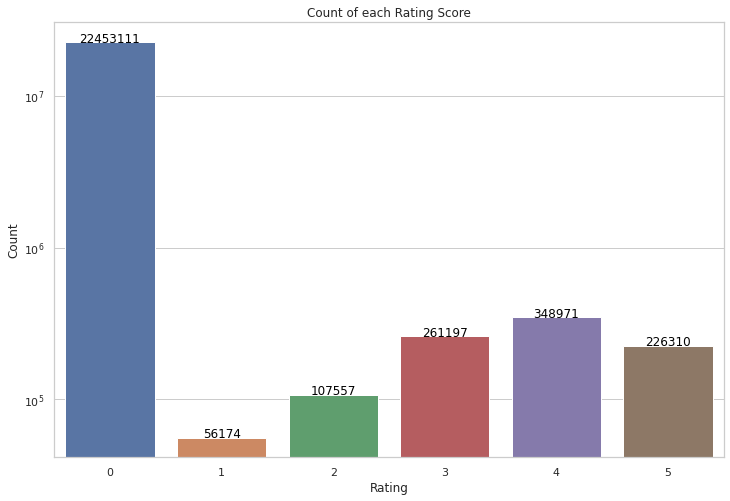

In [309]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,8))
ax = sns.barplot(x=ratingsCounts.index, y='Count', data=ratingsCounts)
ax.set(yscale="log")
ax.set_xlabel("Rating")
ax.set_title('Count of each Rating Score')

for index, row in ratingsCounts.iterrows():
    ax.text(index, row.Count, int(row.Count), color='black', ha='center')

In [310]:
movieRatingFrequency = pd.DataFrame(ratings.groupby('MovieID').size(), columns=['Count']).sort_values('Count', ascending=False)
movieRatingFrequency

,Count
MovieID,
2858,3428
260,2991
1196,2990
1210,2883
480,2672
...,...
3237,1
763,1
624,1


Text(0, 0.5, 'nb of ratings per movie')

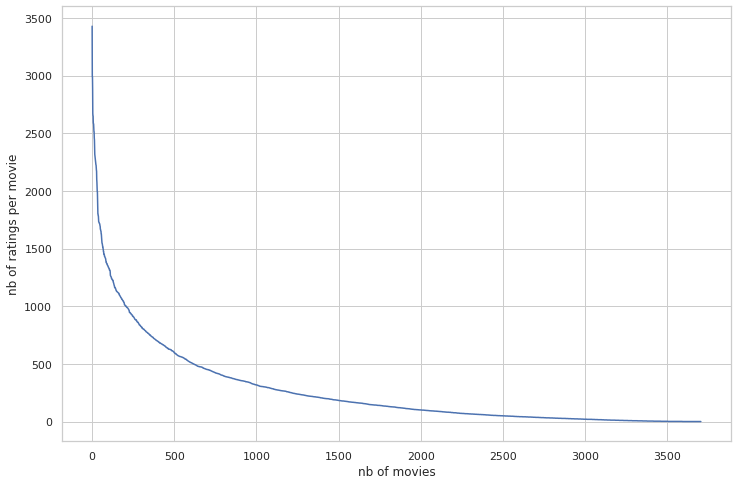

In [311]:
x = range(len(movieRatingFrequency.index))
y = list(movieRatingFrequency['Count'])
plt.figure(figsize=(12,8))
plt.plot(x,y)
plt.xlabel("nb of movies")
plt.ylabel("nb of ratings per movie")

### We can clearly see the popularity (or at least, the ratings frequency) of the movies is quite disparate. 
Let's see what a good cutoff point could be.

In [312]:
moviesKeptPortion = movieRatingFrequency.quantile(np.arange(1, 0.49, -0.05))
moviesKeptPortion['Nb of Movies Left'] = len(movieRatingFrequency) * (1 - moviesKeptPortion.index)
moviesKeptPortion

,Count,Nb of Movies Left
1.00,3428.00,0.0
0.95,1051.50,185.3
0.90,729.50,370.6
0.85,553.25,555.9
0.80,429.00,741.2
0.75,350.00,926.5
0.70,280.00,1111.8
0.65,228.00,1297.1
0.60,188.00,1482.4
0.55,154.00,1667.7


#### Thus, we see if we keep the movies with above 120 ratings, we keep 50% of our total number of movies, which is over 1850.
Let's discard those with less than 120 reviews.

In [313]:
popularMoviesRF = movieRatingFrequency[movieRatingFrequency["Count"] >= 200]
popularMoviesRF.head()

,Count
MovieID,
2858,3428
260,2991
1196,2990
1210,2883
480,2672


In [509]:
ratings_df = ratings.merge(popularMoviesRF, left_on='MovieID', right_on=popularMoviesRF.index, how='inner' )
ratings_df.head()

,UserID,MovieID,Rating,Count
0,1,1193,5,1725
1,2,1193,5,1725
2,12,1193,4,1725
3,15,1193,4,1725
4,17,1193,5,1725


In [512]:
keptMovies = movies.merge(popularMoviesRF, left_on='MovieID', right_on=popularMoviesRF.index, how='inner').drop('Count', axis=1)
keptMovies

,MovieID,Title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,5,Father of the Bride Part II (1995)
4,6,Heat (1995)
...,...,...
1421,3930,"Creature From the Black Lagoon, The (1954)"
1422,3932,"Invisible Man, The (1933)"
1423,3948,Meet the Parents (2000)
1424,3949,Requiem for a Dream (2000)


In [315]:
validation = pd.DataFrame(ratings_df.groupby(['MovieID']).size(), columns=['Size'])
validation = validation.merge(ratings_df, left_on=validation.index, right_on = 'MovieID', how='inner')
validation = np.sum(validation['Size'] != validation['Count'])
print("There are {} unmatched counts.".format(validation))

There are 0 unmatched counts.


### Now, let's remove the users with too few movies as they may turn out to be problematic

In [316]:
userIDFrequency = pd.DataFrame(ratings_df.groupby('UserID').size(), columns=['Count'])
userKeptPortion = userIDFrequency.quantile(np.arange(1, 0, -0.05))
userKeptPortion

,Count
1.00,1192.00
0.95,465.00
0.90,343.00
0.85,272.00
0.80,220.20
0.75,183.25
0.70,154.00
0.65,131.00
0.60,114.00
0.55,98.00


# Number of Ratings per User

### It appears only roughly 5% of our users have less than 22 ratings, which seems diversified enough so we will keep the top 95%.

In [317]:
activeUsers = userIDFrequency[userIDFrequency['Count'] >= 41]
activeUsers

,Count
UserID,
1,50
2,122
3,50
5,150
6,62
...,...
6035,230
6036,672
6037,182


In [318]:
ratings_df = ratings_df.drop("Count", axis=1).merge(activeUsers, left_on = 'UserID', right_on=activeUsers.index, how='inner')
ratings_df.head()

,UserID,MovieID,Rating,Count
0,1,1193,5,50
1,1,661,3,50
2,1,914,3,50
3,1,3408,4,50
4,1,2355,5,50


### We can now construct the dataframe we want to work with by turning our ratings into a table where the rows are the movies and the columns are the users. 
#### We will use this dataframe to create a sparse matrix which will be used in our KNN to compute the cosine similarity.

## A few notes on cosine similarity:
 - The cosine function goes from 1 to -1 as the angle between the vectors goes from 0 to 180 degrees, respectively. 
 - The cosine similarity is a metric that compares two vectors, regardless of their size, and measures the cosine of the angle between them.
 - Thus, we can use the cosine similarity even if it disregards the size is only a scalar which can be interpreted as severity and doesn't impact movie preferences. It would just mean one user is more keen to rate movies higher than the other, but the interests "point in the same direction".  

Consider the following example with two movies and three users:

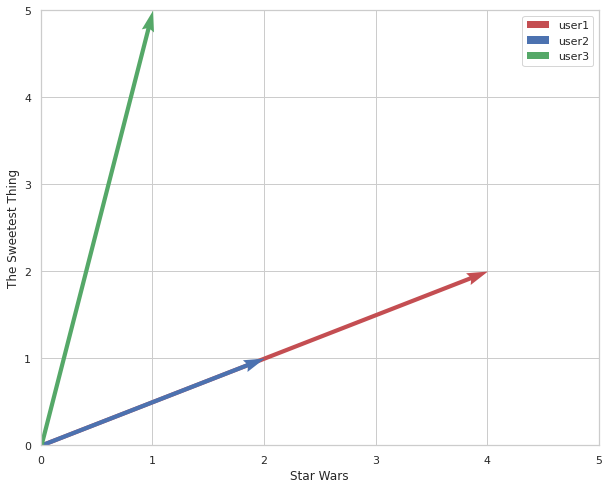

In [319]:
plt.figure(figsize=(10,8))
user1 = plt.quiver([0],[0],[4],[2], color='r', angles='xy', scale_units='xy', scale=1)
user2 = plt.quiver([0],[0], [2],[1], color='b', angles='xy', scale_units='xy', scale=1)
user3 = plt.quiver([0],[0], [1],[5], color='g', angles='xy', scale_units='xy', scale=1)
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.xlabel('Star Wars')
plt.ylabel('The Sweetest Thing')
plt.legend(['user1','user2','user3'])
plt.show()

From above, we can see that when it comes to rating Star Wars and The Sweetest Thing, user3 highly prefers the latter while our two other users favor the former. 
<br>This could be due to the different genres. We could assume users 1 and 2 prefer sci-fi to romance. 
<br>We can think of the direction as the main feature that guides preferences. That is, if two users' vector is in the same direction, their preferences should be alligned and therefore very similar, regardless of the rating values themselves. 

## Moving on

### Let us look at what a cosine distance matrix looks like in dimensions larger than 2.

In [320]:
df = ratings_df
df = df.pivot(index='MovieID', columns='UserID', values='Rating')
df.head()

UserID,1,2,3,5,6,8,9,10,11,13,...,6028,6030,6031,6032,6033,6035,6036,6037,6039,6040
MovieID,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,4.0,4.0,5.0,5.0,NaN,NaN,...,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,3.0,...,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN


In [321]:
cosine_dist = cosine_distances(df.transpose().fillna(0))

labels = list(df.columns)
index = range(0,df.shape[1])

ind_rename = {ind: labels[i] for i, ind in enumerate(index)}

cosine_dist = pd.DataFrame(cosine_dist, columns=labels).rename(index=ind_rename)
cosine_dist.head()

,1,2,3,5,6,8,9,10,11,13,...,6028,6030,6031,6032,6033,6035,6036,6037,6039,6040
1,0.000000,0.898339,0.875314,0.894626,0.803807,0.864081,0.763473,0.731348,0.859051,0.867319,...,0.958444,0.922288,0.814021,0.912403,0.927029,0.876050,0.782052,0.853845,0.820839,0.848409
2,0.898339,0.000000,0.844694,0.867404,0.890495,0.779819,0.802713,0.757376,0.788642,0.668183,...,0.840646,0.845732,0.878358,0.903363,0.721578,0.805708,0.741674,0.780118,0.927452,0.757690
3,0.875314,0.844694,0.000000,0.928533,0.920617,0.917583,0.871439,0.776045,0.817383,0.710568,...,0.892855,0.927706,0.901488,0.869317,0.835896,0.897945,0.837112,0.887433,0.898704,0.853142
5,0.894626,0.867404,0.928533,0.000000,0.942920,0.750222,0.699637,0.861286,0.738749,0.861256,...,0.883062,0.924864,0.879411,0.958056,0.929001,0.787659,0.667986,0.798803,0.966507,0.714933
6,0.803807,0.890495,0.920617,0.942920,0.000000,0.915451,0.880374,0.772529,0.940906,0.941780,...,0.946264,0.991177,0.958387,0.911846,0.974894,0.942345,0.887331,0.927218,0.825863,0.902549


The cosine_distances returned by sklearn is a symmetrical matrix with the main diagonal equal to 0 (because the cosine distance between a vector and itself is 0) and the rest are distances with respect to each indices.
<br>
<br><b>I.e.</b> cosine_dist[0][5762] = cosine_dist[5762][0] = cosine distance between array 0 and array 5762 (UserID 1 and 6040 respectively)
<br>
#### Now, let's create a dictionary to map each title to a movie ID.

In [513]:
movie_to_idx = {
    movie.MovieID: re.sub(r'\([^()]*\)', '', movie.Title).strip() for ind, movie in keptMovies.iterrows()
}

# To make predictions for yourself you have to:
- Provide some movies ratings in order to match you with other users
- The ratings provided must be on movies that are part of our data
- To know if your movie is in our data, type the title in the title below
- If any match is found, take note of the movie ID in the first position of the tuple
- Then lastly, change prediction[YOUR_MOVIE_ID] = YOUR RATING

In [323]:
def movie_getter(title, movie_to_idx):
    # Takes in a string and a dictionary to find titles containing
    # the string and returns the titles as well as the movie ID.
    #
    # INPUTS 
    # title : string
    # movie_to_idx: dictionary of {MovieID: Title}
    #
    # OUTPUTS
    # matching_titles: list of matched titles with their movie ID
    
    matching_titles = []

    for entry in movie_to_idx:
        pattern = title.lower()
        findings = re.match(pattern, movie_to_idx[entry].lower())

        if findings:
            matching_titles.append((entry, movie_to_idx[entry]))

    return matching_titles

In [515]:
liked_movie = "Star Wars"

tuples = movie_getter(liked_movie, movie_to_idx )
tuples

[(260, 'Star Wars: Episode IV - A New Hope'),
 (1196, 'Star Wars: Episode V - The Empire Strikes Back'),
 (1210, 'Star Wars: Episode VI - Return of the Jedi'),
 (2628, 'Star Wars: Episode I - The Phantom Menace')]

In [516]:
Yp = df.copy().truncate(before=0, after=0,axis='columns')
prediction = {movie:np.nan for movie in list(Yp.index)}

### Run the cell below after updating your own prediction array with your own ratings

In [517]:
prediction[1] = 5
prediction[260] = 5
#prediction[1196] = 5
prediction[1210] = 5
#prediction[1566] = 5
prediction[2628] = 2
prediction[1045] = 1
prediction[3554] = 1

Yp['newUser'] = Yp.index.map(prediction)

#Yp.head()

Y = df.copy()
Y.insert(value=pd.Series(data=Yp.newUser, index=Yp.index), column='newUser', loc=len(df.columns))

In [518]:
n_neigh=3


knn_model = NearestNeighbors(n_neighbors=n_neigh, algorithm='brute', metric='cosine')

In [519]:
users_movies = Y.copy().transpose().fillna(0).reset_index(drop=True)

In [520]:
sparse_users_movies = csr_matrix(users_movies)

In [521]:
knn_model.fit(sparse_users_movies)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [522]:
dist, ind = knn_model.kneighbors(sparse_users_movies[sparse_users_movies.shape[0]-1], n_neighbors=n_neigh)

#remove references to self when comparing arrays cosine distances
dist = dist[:,1:]
ind = ind[:,1:]

In [523]:
# Ignore movies already rated
already_rated = list(Yp[Yp['newUser'].fillna(0) != 0].index)


unrated_users_movies = users_movies.drop(already_rated, axis=1)

recommendations = list(unrated_users_movies.iloc[ind[0]].replace(0, np.nan).mean().sort_values(ascending=False)[:10].index)

In [524]:
dict_for_preds = {movieID: (index, movies[movies['MovieID']==movieID]['Title'].values[0]) for index, movieID in enumerate(list(df.transpose().columns))}

In [525]:
for movie in recommendations:
    print(dict_for_preds[movie])

(1390, 'X-Men (2000)')
(259, 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)')
(469, 'Great Escape, The (1963)')
(465, 'Shining, The (1980)')
(450, 'Glory (1989)')
(412, 'Star Wars: Episode V - The Empire Strikes Back (1980)')
(383, 'Top Gun (1986)')
(968, 'Matrix, The (1999)')
(998, 'Austin Powers: The Spy Who Shagged Me (1999)')
(106, 'Pulp Fiction (1994)')
